# Adversarial attacks using TorchANI models and data

In this notebook, we use TorchANI ([paper](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00451) and [source code](https://github.com/aiqm/torchani)) to show that adversarial attacks on uncertainty gives distinct configurations from the training data, as shown in the supporting information of [our paper](https://arxiv.org/abs/2101.11588).

The notebook uses the models with the helper functions in the `robust` folder in this repo and requires installation of the [`torchani`](https://github.com/aiqm/torchani) package.

In [1]:
! pip install torchani
! wget https://www.dropbox.com/sh/2c8zdqc1hrqsgwy/AAD6l24ngoiFa6DRapF6HPk5a/ -O download.zip
! unzip download.zip -d download || [[ $? == 2 ]]

--2021-05-31 15:46:25--  https://www.dropbox.com/sh/2c8zdqc1hrqsgwy/AAD6l24ngoiFa6DRapF6HPk5a/
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/2c8zdqc1hrqsgwy/AAD6l24ngoiFa6DRapF6HPk5a [following]
--2021-05-31 15:46:25--  https://www.dropbox.com/sh/raw/2c8zdqc1hrqsgwy/AAD6l24ngoiFa6DRapF6HPk5a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce181312d3351adf5b8b7b805d8.dl.dropboxusercontent.com/zip_download_get/Ay9Xd313y-nLlJdfqVMBCMJGbgsXKRof8OaUf-3muHqGf9XWWpUEaKbozXvkoTp6w3DaakeN6E1mJeW0U97YdSksNBfw1TLUCe8tHifsPK6qHQ# [following]
--2021-05-31 15:46:26--  https://uce181312d3351adf5b8b7b805d8.dl.dropboxusercontent.com/zip_download_get/Ay9Xd313y-nLlJdfqVMBCMJGbgsXKRof8OaUf-3muHqGf9XWWpUEaKbozXvkoTp6w3DaakeN6E1mJeW0U97Y

In [2]:
import sys
sys.path.append('..')

import robust as rb
import torch
import torchani
import ase
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from robust.geom import compute_rmsd

# Load ANI-1x data

ANI-1x dataset contains organic molecules built from H, C, N, and O elements. In this specific file `ani_gdb_s01.h5`, there are only three unique molecules ($H_2O$, $CH_4$, and $NH_3$). 

Note that subtracting energies by the self energies of all atoms for each molecule makes the range of energies reasonable. For more information, refer to [TorchANI paper](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00451).

In [3]:
species_order = ['H', 'C', 'N', 'O']
energy_shifter = torchani.utils.EnergyShifter(None)

dspath = 'download/dataset/ani1-up_to_gdb4/ani_gdb_s01.h5'
data = torchani.data.load(dspath)
dset = list(data.subtract_self_energies(energy_shifter, species_order).species_to_indices())

# Load torchANI.ANI1ccx ensemble models

Loading ANI-1ccx models from `torchANI` package. ANI-1ccx was trained to the ANI-1x data set and then retrained to a 10% smaller data set of accurate coupled cluster calculations. 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = torchani.models.ANI1ccx(periodic_table_index=False).to(device)

# Perform adversarial attack 

Now we select the parameters for adversarial attacks to find configurations with high uncertainty. We randomly choose seed configurations to maximize adversarial loss on. 

In [5]:
num_attacks = 100
lr = 1e-4
kT = 1.0
n_epochs = 100

Get energy distribution for each molecule to build individual `AdvLoss` functions. 

In [6]:
ch_format = {"CHHHH": "CH4", 'NHHH': 'H3N', 'OHH': 'H2O'}
atomic_number = {'H': 1, 'C': 6, 'N': 7, 'O': 8}

In [7]:
energies = {}
for d in data:
    mol = ch_format["".join(d['species'])]
    energies[mol] = energies.get(mol, [])
    energies[mol].append(torchani.units.hartree2kcalmol(d['energies']))
    
loss_fn = {}
for mol in energies.keys():
    potential_dset = rb.PotentialDataset(
            x=np.zeros((len(energies[mol]))),
            energy=np.array(energies[mol]) - np.array(energies[mol]).min(),
            forces=np.zeros((len(energies[mol]), 3)),
    )
    loss_fn[mol] = rb.AdvLoss(train=potential_dset, temperature=kT)

Starting adversarial attack

In [8]:
batch_size = 1
seed_data = [dset[i] for i in torch.randperm(len(dset))[:num_attacks]]
loader = torchani.data.TransformableIterable(seed_data).collate(batch_size)

print("Step |     AdvLoss     | Delta  | Energy  |  Force  |  Fstd  | RMSD ")

molecules, energy, force_std, rmsd = [], [], [], []
for i, batch in enumerate(loader):
    species = batch['species'].to(device)
    coordinates = batch['coordinates'].to(device)
    coordinates.requires_grad = True
    
    delta = torch.zeros_like(coordinates, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([delta], lr=lr)
    
    # Get atomic numbers and coordinates of seed configuration
    z = torch.tensor(list(map(lambda x: atomic_number[species_order[x.item()]], batch['species'].squeeze())))
    orig_mol = ase.Atoms(numbers=z, 
                         positions=coordinates[:len(z)].squeeze().cpu().detach().numpy())
    v = np.concatenate([orig_mol.get_atomic_numbers().reshape(-1, 1), orig_mol.get_positions()], axis=1)
    formula = orig_mol.get_chemical_formula()

    molecules.append(formula)
    energy.append([])
    force_std.append([])
    rmsd.append([])
    
    for epoch in range(n_epochs+1):
        optimizer.zero_grad()

        coordinates = coordinates + delta

        results = [model((species, coordinates)) for model in models]

        pred_energies = torch.stack([torchani.units.hartree2kcalmol(r.energies) - np.array(energies[formula]).min() for r in results], dim=1)
        pred_forces = torch.stack(
            [-torch.autograd.grad(
                torchani.units.hartree2kcalmol(r.energies), coordinates, allow_unused=True, retain_graph=True
            )[0] for r in results], dim=1).squeeze()

        loss = loss_fn[formula].loss_fn(x=None, e=pred_energies, f=pred_forces).sum()

        loss.backward()
        optimizer.step()
        
        # calculate rmsd from seed configuration
        disturbed_mol = ase.Atoms(numbers=np.array(z), 
                                      positions=coordinates[:len(z)].squeeze().cpu().detach().numpy())
        w = np.concatenate([disturbed_mol.get_atomic_numbers().reshape(-1, 1), 
                            disturbed_mol.get_positions()], axis=1)
        rmsd_vw = rb.compute_rmsd(v, w)
        
        # save values 
        energy[i].append(pred_energies.mean(-1).item())
        force_std[i].append(pred_forces.std(0).mean().item())
        rmsd[i].append(rmsd_vw)

        if epoch % 20 == 0:
            print("{:>4d} | {:>10.8e} | {:>5.4f} | {:>5.4f} | {:>5.4f} | {:>5.4f} | {:.4f}".format(epoch, 
                                                                                        loss.item(), 
                                                                                        delta.abs().sum().item(), 
                                                                                        pred_energies.mean(-1).item(),
                                                                                        pred_forces.abs().mean(),
                                                                                        pred_forces.std(0).mean(),
                                                                                        rmsd_vw))

Step |     AdvLoss     | Delta  | Energy  |  Force  |  Fstd  | RMSD 
   0 | -4.39396761e-05 | 0.0012 | 22.0656 | 34.0913 | 5.1459 | 0.0000
  20 | -1.57432742e-03 | 0.0220 | 16.7978 | 16.2944 | 3.7847 | 0.0294
  40 | -2.11185935e-03 | 0.0263 | 19.1190 | 37.1461 | 4.4162 | 0.0984
  60 | -3.95215491e-04 | 0.0255 | 20.1854 | 39.5528 | 3.5499 | 0.1685
  80 | -2.29854854e-05 | 0.0258 | 23.1135 | 33.5851 | 3.9299 | 0.2307
 100 | -2.19968371e-11 | 0.0269 | 37.9655 | 45.0848 | 8.7561 | 0.2900
   0 | -8.98317515e-14 | 0.0000 | 42.6955 | 33.4611 | 4.3024 | 0.0000
  20 | -9.16408578e-14 | 0.0001 | 42.6728 | 33.4233 | 4.3068 | 0.0001
  40 | -1.05338000e-13 | 0.0003 | 42.5149 | 33.1647 | 4.3389 | 0.0005
  60 | -1.59672781e-13 | 0.0008 | 42.0385 | 32.3764 | 4.4214 | 0.0019
  80 | -4.24809114e-13 | 0.0019 | 40.9150 | 30.5150 | 4.6092 | 0.0053
 100 | -4.50190557e-12 | 0.0071 | 38.1322 | 25.2925 | 4.2889 | 0.0152
   0 | -4.48531444e-03 | 0.0006 | 18.8831 | 71.1758 | 11.7654 | 0.0000
  20 | -7.79546641e+

  40 | -2.41144103e-06 | 0.0381 | 25.6092 | 20.7153 | 2.8491 | 0.1066
  60 | -1.87630397e-07 | 0.0406 | 27.4798 | 16.8150 | 3.2966 | 0.1915
  80 | -1.30678392e-20 | 0.0429 | 60.0623 | 56.1533 | 7.0953 | 0.2780
 100 | -3.33710469e-46 | 0.0434 | 119.8504 | 92.2592 | 14.3875 | 0.3735
   0 | -2.23927865e-03 | 0.0012 | 18.2506 | 20.4279 | 5.0264 | 0.0000
  20 | -2.13655734e-02 | 0.0230 | 14.8532 | 10.8532 | 4.2348 | 0.0304
  40 | -3.38650906e-01 | 0.0254 | 13.1707 | 19.7366 | 3.4507 | 0.1053
  60 | -2.45253462e-03 | 0.0312 | 18.3480 | 28.1521 | 3.3921 | 0.1875
  80 | -6.48509099e-15 | 0.0330 | 47.0208 | 67.1580 | 7.4249 | 0.2796
 100 | -6.42595968e-30 | 0.0333 | 82.1361 | 84.6191 | 12.3061 | 0.3811
   0 | -2.49660278e+00 | 0.0006 | 11.0731 | 22.4480 | 3.9156 | 0.0000
  20 | -2.47193931e+01 | 0.0158 | 7.9835 | 12.7038 | 3.1326 | 0.0245
  40 | -6.37287352e+02 | 0.0205 | 5.1994 | 22.1524 | 3.1975 | 0.0888
  60 | -5.86827665e+02 | 0.0287 | 5.2206 | 22.4796 | 2.9914 | 0.1571
  80 | -6.83607585e-

 100 | -1.29507592e-13 | 0.0405 | 42.7419 | 44.4558 | 16.5711 | 0.3630
   0 | -1.27318010e-08 | 0.0014 | 30.3572 | 23.4166 | 2.9307 | 0.0000
  20 | -1.56482601e-07 | 0.0279 | 25.7754 | 11.6879 | 1.6066 | 0.0312
  40 | -3.25283364e-07 | 0.0277 | 27.5596 | 29.4819 | 3.1721 | 0.1005
  60 | -2.89818801e-07 | 0.0310 | 26.3304 | 19.0604 | 3.2922 | 0.1504
  80 | -1.35072045e-12 | 0.0396 | 41.4550 | 48.3799 | 4.4819 | 0.1928
 100 | -2.39799435e-36 | 0.0406 | 97.8813 | 103.5750 | 10.8851 | 0.2494
   0 | -1.14749410e-01 | 0.0012 | 14.6233 | 24.1086 | 3.2076 | 0.0000
  20 | -1.29991909e-01 | 0.0233 | 11.9395 | 7.0565 | 2.8426 | 0.0304
  40 | -4.74837116e-02 | 0.0156 | 15.5514 | 23.3291 | 2.7975 | 0.0875
  60 | -1.96073287e-02 | 0.0211 | 15.9432 | 22.8263 | 4.0353 | 0.1309
  80 | -1.29169673e-04 | 0.0259 | 21.2019 | 24.6342 | 5.3864 | 0.1708
 100 | -1.89785988e-15 | 0.0268 | 48.8571 | 83.5128 | 13.6116 | 0.2155
   0 | -1.07791985e+02 | 0.0006 | 7.5078 | 37.8575 | 4.2095 | 0.0000
  20 | -4.74029664

  40 | -1.13310145e-03 | 0.0209 | 18.8975 | 50.6902 | 5.6650 | 0.0925
  60 | -6.44471809e-25 | 0.0198 | 71.1086 | 188.9192 | 42.1484 | 0.1481
  80 | -2.17925841e-80 | 0.0198 | 199.6818 | 241.3314 | 82.3919 | 0.2060
 100 | -2.39020970e-120 | 0.0198 | 291.2007 | 141.8245 | 63.0317 | 0.2661
   0 | -7.38432069e-13 | 0.0000 | 41.4288 | 39.4278 | 5.5528 | 0.0000
  20 | -9.29775660e-13 | 0.0007 | 41.1794 | 39.0661 | 5.4893 | 0.0006
  40 | -5.73223183e-12 | 0.0044 | 39.1782 | 35.8085 | 4.9348 | 0.0057
  60 | -6.99786038e-09 | 0.0317 | 30.3454 | 16.2787 | 2.3290 | 0.0407
  80 | -2.02646247e-09 | 0.0401 | 33.8299 | 39.1898 | 2.9685 | 0.1345
 100 | -3.52060854e-14 | 0.0408 | 45.3807 | 53.7545 | 3.9376 | 0.2352
   0 | -5.10885319e-05 | 0.0012 | 23.9138 | 51.1334 | 7.4698 | 0.0000
  20 | -1.08311279e-02 | 0.0212 | 16.3220 | 20.5197 | 4.4016 | 0.0296
  40 | -9.77511551e-03 | 0.0295 | 17.2518 | 26.7250 | 3.2473 | 0.1041
  60 | -3.62598287e-06 | 0.0295 | 25.7981 | 40.1926 | 4.4003 | 0.1858
  80 | -2.6

 100 | -3.06329308e-30 | 0.0278 | 82.5913 | 91.4873 | 12.8767 | 0.3261
   0 | -9.57466705e-14 | 0.0000 | 42.6319 | 26.4681 | 3.0433 | 0.0000
  20 | -9.74042347e-14 | 0.0001 | 42.6124 | 26.4486 | 3.0429 | 0.0001
  40 | -1.09775716e-13 | 0.0002 | 42.4764 | 26.3133 | 3.0407 | 0.0005
  60 | -1.56858953e-13 | 0.0006 | 42.0691 | 25.9030 | 3.0318 | 0.0018
  80 | -3.55968860e-13 | 0.0015 | 41.1252 | 24.9094 | 3.0052 | 0.0049
 100 | -2.38346938e-12 | 0.0047 | 38.8956 | 22.6592 | 2.9487 | 0.0130
   0 | -7.66024537e-16 | 0.0000 | 47.9706 | 33.5090 | 5.8718 | 0.0000
  20 | -7.66132716e-16 | 0.0000 | 47.9704 | 33.5088 | 5.8717 | 0.0000
  40 | -7.67036847e-16 | 0.0000 | 47.9691 | 33.5064 | 5.8717 | 0.0000
  60 | -7.69670999e-16 | 0.0000 | 47.9653 | 33.4998 | 5.8714 | 0.0000
  80 | -7.75073192e-16 | 0.0000 | 47.9576 | 33.4862 | 5.8708 | 0.0000
 100 | -7.84350492e-16 | 0.0000 | 47.9445 | 33.4632 | 5.8698 | 0.0001
   0 | -2.37210375e-09 | 0.0010 | 33.0164 | 69.8675 | 12.6142 | 0.0000
  20 | -1.15237326

  40 | -1.20050203e-07 | 0.0366 | 28.9641 | 28.5820 | 3.1704 | 0.0895
  60 | -1.54233882e-11 | 0.0365 | 38.7547 | 43.8584 | 3.8790 | 0.1504
  80 | -3.74829475e-16 | 0.0367 | 49.4779 | 48.9150 | 5.3956 | 0.2154
 100 | -9.00641613e-22 | 0.0367 | 62.2543 | 45.4281 | 8.5496 | 0.2846
   0 | -3.35354249e-07 | 0.0015 | 25.7423 | 15.7652 | 1.9934 | 0.0000
  20 | -2.91041014e-06 | 0.0252 | 22.9204 | 7.2208 | 1.6273 | 0.0312
  40 | -7.51668871e-08 | 0.0290 | 28.4297 | 29.0187 | 4.9335 | 0.0975
  60 | -4.02781445e-13 | 0.0288 | 42.1465 | 46.6036 | 6.5351 | 0.1594
  80 | -8.28446308e-24 | 0.0288 | 67.9259 | 70.6762 | 8.3981 | 0.2246
 100 | -1.43319747e-39 | 0.0288 | 105.1405 | 88.4078 | 12.3881 | 0.2919
   0 | -1.25490152e+00 | 0.0006 | 12.2064 | 25.5980 | 2.9511 | 0.0000
  20 | -1.76196836e+01 | 0.0124 | 8.5185 | 16.5715 | 3.0691 | 0.0232
  40 | -2.30128556e+02 | 0.0200 | 7.4822 | 35.6279 | 4.3122 | 0.0820
  60 | -6.33363952e+02 | 0.0296 | 3.6257 | 9.5461 | 2.7014 | 0.1440
  80 | -1.92033388e-08 

In [9]:
energy = np.array(energy)
force_std = np.array(force_std)
rmsd = np.array(rmsd)

# Plot evolution of mean force uncertainty and mean rmsd as a function of steps for each molecule

This plot reproduces figure S of the paper, up to differences in the random initialization. It essentially shows distortion of molecules to configurations that corresponds to high uncertainty (high rmsd) of the models. 

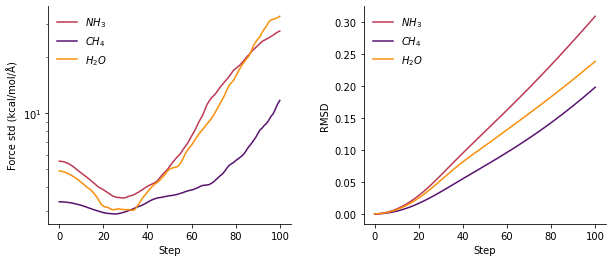

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

cmap = cm.inferno
rnd_cmap = cm.Blues

COLORS = {
    "CH4": cmap(64),
    "H3N": cmap(128),
    "H2O": cmap(192),
}

ce_format = {
    "CH4": "$CH_4$",
    "H3N": "$NH_3$",
    "H2O": "$H_2O$"
}

mol_indices = {mol: [i for i, x in enumerate(molecules) if x == mol] for mol in set(molecules)}
for mol, idx in mol_indices.items():
    fstd_mean = force_std[idx].mean(0)
    rmsd_mean = rmsd[idx].mean(0)
    
    axes[0].plot(range(len(fstd_mean)), fstd_mean, label=ce_format[mol], color=COLORS[mol])
    axes[1].plot(range(len(rmsd_mean)), rmsd_mean, label=ce_format[mol], color=COLORS[mol])

axes[0].set_ylabel("Force std (kcal/mol/Å)")
axes[1].set_ylabel("RMSD")

axes[0].set_yscale("log")

for ax in axes:
    ax.legend(frameon=False)
    ax.set_xlabel("Step")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.subplots_adjust(wspace=0.30)
plt.show()